# Feature Selection:


Feature selection is a process of selecting a subset of relevant features or variables from a larger set of features that are available in a dataset. It is done to improve the performance of a machine-learning model by reducing the complexity of the data and preventing overfitting. The main objective of feature selection is to remove irrelevant, redundant, or noisy features that do not contribute significantly to the predictive accuracy of the model while retaining the most important features that capture the underlying patterns in the data.


In [1]:
# In this project we are using Filter methods( based on KS score and Fraud detection@ #% ) and Wrapper for 
# selection of top 25 variables depending upon their filter score and multivariate importance
#(Using multivariate importance in a wrapper method can help to identify the most important features
#for a particular problem, taking into account their interactions and joint contribution to the model output.)


This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 200
# I recommend set num_wrapper to be abt 30, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1


## Run a filter on all the files

In [5]:
# Aim of using filter is to figure out how imporant each. variable is by itself to predict y.
## using filter method to filter top 240 variables based on KS Score

In [6]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_new.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_new.csv size is (96397, 1424)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
candidate_variables_new.csv                         variable  filter score
0                          Fraud      1.000000
421            card_zip3_total_7      0.696009
412            card_zip3_total_3      0.688061
229             card_zip_total_7      0.684517
430           card_zip3_total_14      0.681898
165           card_merch_total_7      0.681641
220             card_zip_total_3      0.677563
174          card_merch_total_14      0.676091
156           card_merch_total_3      0.675454
238            card_zip_total_14      0.671828
485       Card_Merchdesc_total_7      0.671267
403            card_zip3_total_1      0.666443
613   Card_Merchnum_desc_total_7      0.666114
494      Card_Merchdesc_total_14      0.665538
419              card_zip3_max_7      0.665218
622  Card_Merchnum_desc_total_14      0.663289
476       Card_Merchdesc_total_3      0.

In [7]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [8]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.696009
2,card_zip3_total_3,0.688061
3,card_zip_total_7,0.684517
4,card_zip3_total_14,0.681898
5,card_merch_total_7,0.681641
6,card_zip_total_3,0.677563
7,card_merch_total_14,0.676091
8,card_merch_total_3,0.675454
9,card_zip_total_14,0.671828


In [9]:
filter_score.tail()

,variable,filter score
1419,Card_Merchnum_desc_unique_count_for_zip3_3,0.000549
1420,Card_Merchnum_desc_unique_count_for_zip3_1,0.000462
1421,Merchnum_unique_count_for_zip3_3,0.000337
1422,Merchnum_desc_unique_count_for_zip3_14,0.000312
1423,card_merch_unique_count_for_Cardnum_1,0.000000


In [10]:
filter_score.shape

(1424, 2)

In [11]:
#filter_score.to_csv('filter_full.csv')

In [12]:
#filter_score.to_csv('filter_full_new.csv', index=False)

In [13]:
filter_score.head(20).to_csv('filter_top2.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip3_total_3', 'card_zip_total_7', 'card_zip3_total_14', 'card_merch_total_7', 'card_zip_total_3', 'card_merch_total_14', 'card_merch_total_3', 'card_zip_total_14', 'Card_Merchdesc_total_7', 'card_zip3_total_1', 'Card_Merchnum_desc_total_7', 'Card_Merchdesc_total_14', 'card_zip3_max_7', 'Card_Merchnum_desc_total_14', 'Card_Merchdesc_total_3', 'card_zip3_total_30', 'card_zip_total_1', 'card_merch_total_30', 'Card_Merchdesc_max_14', 'card_zip3_max_14', 'card_merch_total_1', 'card_zip_max_14', 'card_zip_max_7', 'card_zip3_max_3', 'Card_Merchdesc_total_30', 'Card_Merchdesc_max_7', 'Card_Merchnum_desc_total_30', 'card_zip_total_30', 'Card_Merchnum_desc_total_3', 'Card_Merchnum_desc_max_14', 'card_merch_max_14', 'Card_Merchdesc_max_30', 'Card_Merchnum_desc_max_30', 'Card_Merchnum_desc_max_7', 'card_merch_max_30', 'card_merch_max_7', 'card_zip_max_30', 'Card_Merchdesc_max_3', 'card_zip_max_3', 'Card_Merchnum_desc_total_60', 'card_zip_total_60', 'Card_

In [14]:
### keeping top 300 variables  based on KS score

vars_keep_df = pd.DataFrame({'col':vars_keep})
#vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip3_total_3,card_zip_total_7,card_zip3_total_14,card_merch_total_7,card_zip_total_3,card_merch_total_14,card_merch_total_3,card_zip_total_14,Card_Merchdesc_total_7,...,Cardnum_med_3,Merchnum_desc_total_14,merch_zip_med_0,Merchnum_med_0,Merchnum_desc_med_0,zip3_total_0,card_zip3_med_14,zip3_actual/avg_30,Cardnum_avg_14,Merchnum_desc_avg_7
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,174.20,1023.04,1023.04,1023.04,174.20,1023.04,174.20,1023.04,1023.04,...,174.200,9711.43,174.20,174.20,174.20,174.20,174.200,0.666299,242.005714,284.698333
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,250.000,530.00,250.00,250.00,250.00,250.00,250.000,0.820505,421.875000,250.000000
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,...,38.425,4106.55,53.88,53.88,53.88,53.88,38.425,0.261078,387.050000,222.632857
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,154.630,26728.80,1269.00,1269.00,1269.00,1269.00,1269.000,1.445527,300.931667,920.238235
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,288.380,2670.60,288.38,288.38,288.38,288.38,288.380,0.726705,579.541667,411.470000


In [15]:
df_keep.shape

(80983, 200)

In [16]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [17]:
Y = Y.values
Y_save = Y.copy()

In [18]:
Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [19]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:33.792560


In [20]:
print(X.shape,Y.shape)

(80983, 200) (80983, 1)


In [21]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [22]:
## will setup FDR@3 % 
#the FDR (Fraud Detection Rate) indicates the percentage of all detected frauds at a 
#specific threshold level. For instance, if the FDR is 55% at a 3% threshold, it means that
#the model can detect 55% of all frauds within 3% of the total population.

In [23]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the probability list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [24]:
# Selection top 25 features sorted by their multivariate importance

Wrapper forward selection is a feature selection technique that involves building a model with a subset of the available features and evaluating its performance. The wrapper forward selection algorithm selects the best subset of features by iteratively adding one feature at a time to the model until the performance improvement reaches a threshold or no further improvement is possible.

In [25]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.


nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
#clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for forward selection
#sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=3,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)


/Users/ankur/tensorflow-test/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankur/tensorflow-test/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankur/tensorflow-test/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ankur/tensorflow-test/env/lib/python3.10/site-packages/sklearn/mod

CPU times: user 15.3 s, sys: 5.96 s, total: 21.3 s
Wall time: 24min 44s


SequentialFeatureSelector(cv=3,
                          estimator=RandomForestClassifier(n_estimators=5),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x122da0310>)

In [27]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:25:17.990256


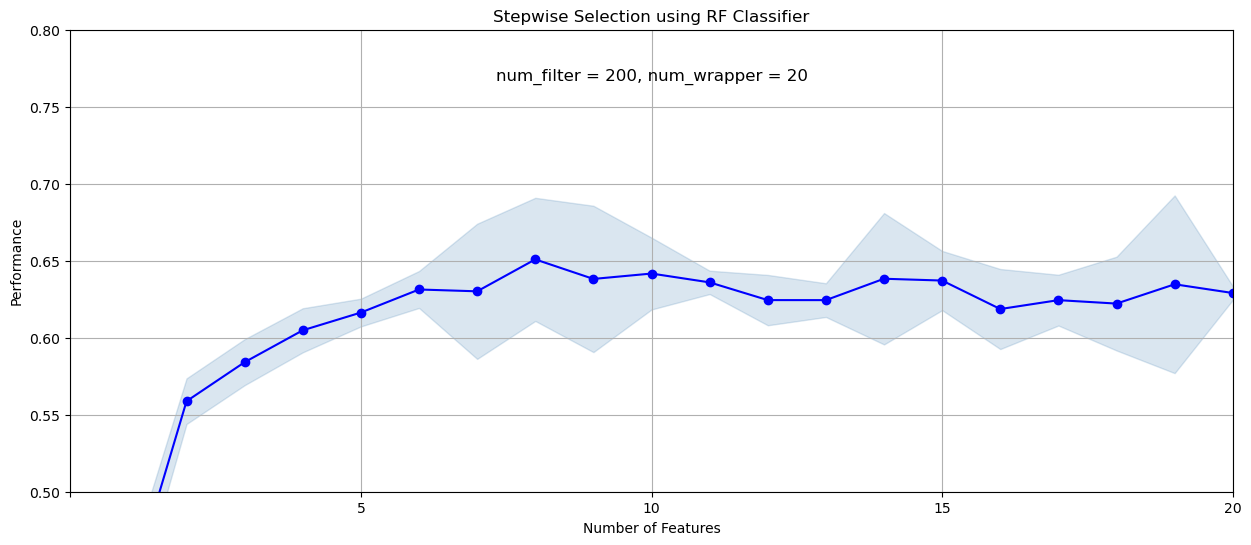

In [28]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.05))
plt.ylim([0.5, 0.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection using RF Classifier')

plt.text(0.5, 0.9, f"num_filter = {num_filter}, num_wrapper = {num_wrapper}",
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes, fontsize=12)

plt.grid()
plt.savefig('performance_nvars_final.png')
plt.show()

In [29]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [30]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names']))[0])
# You might also need this following line. It converts a list to a string
        #         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]
    
    
    


In [31]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.4517241379310345, 0.43944636678200694, 0.40...",0.432005,"(card_zip3_total_3,)",0.044666,0.019849,0.014035,1.0,card_zip3_total_3
2,"(1, 62)","[0.5379310344827586, 0.5674740484429066, 0.570...",0.55878,"(card_zip3_total_3, card_zip3_max_60)",0.033327,0.01481,0.010472,2.0,card_zip3_max_60
3,"(1, 62, 117)","[0.5655172413793104, 0.6020761245674741, 0.584...",0.584123,"(card_zip3_total_3, card_zip3_max_60, Merchnum...",0.033602,0.014932,0.010559,3.0,Merchnum_total_0
4,"(1, 45, 62, 117)","[0.6172413793103448, 0.6124567474048442, 0.584...",0.604824,"(card_zip3_total_3, card_zip3_total_60, card_z...",0.032204,0.014311,0.010119,4.0,card_zip3_total_60
5,"(1, 45, 62, 117, 160)","[0.6275862068965518, 0.615916955017301, 0.6055...",0.616346,"(card_zip3_total_3, card_zip3_total_60, card_z...",0.020269,0.009007,0.006369,5.0,Cardnum_max_3
6,"(1, 45, 47, 62, 117, 160)","[0.6482758620689655, 0.6228373702422145, 0.622...",0.631317,"(card_zip3_total_3, card_zip3_total_60, Card_M...",0.026986,0.011992,0.008479,6.0,Card_Merchdesc_max_60
7,"(1, 45, 47, 62, 72, 117, 160)","[0.6758620689655173, 0.643598615916955, 0.5709...",0.630132,"(card_zip3_total_3, card_zip3_total_60, Card_M...",0.09875,0.043882,0.031029,7.0,merch_zip_total_1
8,"(1, 45, 47, 62, 72, 117, 160, 189)","[0.7, 0.6020761245674741, 0.6505190311418685]",0.650865,"(card_zip3_total_3, card_zip3_total_60, Card_M...",0.089964,0.039978,0.028269,8.0,amount_cat
9,"(1, 23, 45, 47, 62, 72, 117, 160, 189)","[0.7034482758620689, 0.6193771626297578, 0.591...",0.638174,"(card_zip3_total_3, card_zip_max_7, card_zip3_...",0.106934,0.047519,0.033601,9.0,card_zip_max_7
10,"(1, 23, 45, 47, 62, 72, 117, 160, 182, 189)","[0.6724137931034483, 0.6366782006920415, 0.615...",0.64167,"(card_zip3_total_3, card_zip_max_7, card_zip3_...",0.052507,0.023333,0.016499,10.0,zip3_variability_avg_30


In [32]:
ordered_vars_FS.to_csv('Wrapper_selection_new_info.csv', index=False)

In [33]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list_new.csv',index=True)
vars_keep

1             card_zip3_total_3
2              card_zip3_max_60
3              Merchnum_total_0
4            card_zip3_total_60
5                 Cardnum_max_3
6         Card_Merchdesc_max_60
7             merch_zip_total_1
8                    amount_cat
9                card_zip_max_7
10      zip3_variability_avg_30
11              merch_zip_max_7
12                Cardnum_med_1
13            card_merch_max_14
14        Merchnum_desc_total_0
15          Merchnum_desc_max_3
16    Card_Merchnum_desc_max_60
17            card_merch_max_30
18              Cardnum_total_0
19              merch_zip_avg_1
20               Merchnum_max_3
Name: variable name, dtype: object

In [34]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.696009
card_zip3_total_3,0.688061
card_zip_total_7,0.684517
card_zip3_total_14,0.681898
card_merch_total_7,0.681641
...,...
Card_Merchnum_desc_unique_count_for_zip3_3,0.000549
Card_Merchnum_desc_unique_count_for_zip3_1,0.000462
Merchnum_unique_count_for_zip3_3,0.000337


In [35]:
filter_score.head(20)

,filter score
variable,
card_zip3_total_7,0.696009
card_zip3_total_3,0.688061
card_zip_total_7,0.684517
card_zip3_total_14,0.681898
card_merch_total_7,0.681641
card_zip_total_3,0.677563
card_merch_total_14,0.676091
card_merch_total_3,0.675454
card_zip_total_14,0.671828


In [36]:
filter_score.shape

(1423, 1)

In [37]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_zip3_total_3
card_zip3_max_60
Merchnum_total_0
card_zip3_total_60
Cardnum_max_3


In [38]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [39]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted_new3.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_zip3_total_3,0.688061
1,2,card_zip3_max_60,0.611829
2,3,Merchnum_total_0,0.581021
3,4,card_zip3_total_60,0.644359
4,5,Cardnum_max_3,0.561109
5,6,Card_Merchdesc_max_60,0.640838
6,7,merch_zip_total_1,0.604962
7,8,amount_cat,0.544878
8,9,card_zip_max_7,0.657460
9,10,zip3_variability_avg_30,0.548986


In [40]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip3_total_3',
 'card_zip3_max_60',
 'Merchnum_total_0',
 'card_zip3_total_60',
 'Cardnum_max_3',
 'Card_Merchdesc_max_60',
 'merch_zip_total_1',
 'amount_cat',
 'card_zip_max_7',
 'zip3_variability_avg_30',
 'merch_zip_max_7',
 'Cardnum_med_1',
 'card_merch_max_14',
 'Merchnum_desc_total_0',
 'Merchnum_desc_max_3',
 'Card_Merchnum_desc_max_60',
 'card_merch_max_30',
 'Cardnum_total_0',
 'merch_zip_avg_1',
 'Merchnum_max_3',
 'Recnum',
 'Fraud']

In [41]:
len(vars_keep_list)

22

In [42]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 8.02 s, sys: 1.71 s, total: 9.73 s
Wall time: 10.4 s


(96397, 1424)

In [43]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [44]:
df_keep.to_csv('vars_final_new.csv',index=False)

In [45]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:25:29.401682
